In [1]:
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import scipy as sc
mpl.use("pgf")
#plt.rcParams['text.latex.unicode'] = True
plt.rcParams.update({
    "pgf.texsystem":   "pdflatex", # or any other engine you want to use
    "text.usetex":     True,       # use TeX for all texts
    "font.family":     "serif",
    "font.serif":      [],         # empty entries should cause the usage of the document fonts
    "font.sans-serif": [],
    "font.monospace":  [],
    "font.size":       10,         # control font sizes of different elements
    "axes.labelsize":  10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "pgf.preamble": [              # specify additional preamble calls for LaTeX's run
        r"\usepackage[T1]{fontenc}",
        r"\usepackage{siunitx}",
        r"\usepackage[utf8]{inputenc}",
        r"\DeclareUnicodeCharacter{2212}{-}",
    ],
})

In [1]:
from tqdm.notebook import tqdm

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [3]:
from matplotlib.collections import LineCollection

In [4]:
from sympy import symbols, Symbol, expand, collect,sqrt,factor,fraction, diff, elliptic_e, elliptic_k, \
simplify,Poly,lambdify,series, cancel
from sympy.parsing.mathematica import parse_mathematica as prsmat
x = symbols('x')

In [8]:
import numpy as np

### $C_4$ spline

In [5]:
S_0 = prsmat('1 - (2615 x^2)/1344 + (1123 x^4)/672 - (5377 x^5)/6720 + (251 x^6)/3360')
S_1 = prsmat('-(317/1120) + (44503 x)/6720 - (253 x^2)/16 + (10015 x^3)/672 - (\
 1527 x^4)/224 + (1021 x^5)/672 - (297 x^6)/2240')
S_2 = prsmat('4519/224 - (342889 x)/6720 + (17335 x^2)/336 - (18097 x^3)/672 + (\
 5179 x^4)/672 - (1291 x^5)/1120 + (95 x^6)/1344')
S_3 = prsmat('-(24223/1120) + (521041 x)/13440 - (10903 x^2)/384 + (2095 x^3)/192 - (3127 x^4)/1344 + (703 x^5)/2688 - (163 x^6)/13440')
S_4 = prsmat('-(1875/224) + (9375 x)/896 - (4875 x^2)/896 + (675 x^3)/448 - (\
 15 x^4)/64 + (87 x^5)/4480 - (3 x^6)/4480')

f_m4 = Symbol(r'f_{-4}')
f_m3 = Symbol(r'f_{-3}')
f_m2 = Symbol(r'f_{-2}')
f_m1 = Symbol(r'f_{-1}')
f_0 = Symbol(r'f_{0}')
f_1 = Symbol(r'f_{1}')
f_2 = Symbol(r'f_{2}')
f_3 = Symbol(r'f_{3}')
f_4 = Symbol(r'f_{4}')
f_5 = Symbol(r'f_{5}')

f_on_segment_c4 = f_m4*S_4.subs(x,x+4)+\
                f_m3*S_3.subs(x,x+3) +\
                f_m2*S_2.subs(x,x+2)   +\
                 f_m1*S_1.subs(x,x+1)   +\
                 f_0  *S_0.subs(x,x)     +\
                 f_1*S_0.subs(x,-x+1)  +\
                 f_2*S_1.subs(x,-x+2)  +\
                 f_3*S_2.subs(x,-x+3)+\
                 f_4*S_3.subs(x,-x+4)  +\
                 f_5*S_4.subs(x,-x+5)
f_on_segment_c4 = collect(expand(f_on_segment_c4),x)
f_on_segment_r_c4 = collect(expand(f_on_segment_c4.subs(x,x+1)),x) ### for last segment x ~  tau-1

In [7]:
def get_compact_spline(array):
    res = {}
    n = len(array) -1 ## for z type approx ##
    def get_f_j(j):
        if j<0:
            return array[-j]
        if j>n:
            return array[-j%n]
        else:
            return array[j]
    for segment in range(n-1):
        sp_seg = f_on_segment_c4.subs({f_m4:get_f_j(segment-4),
                                    f_m3:get_f_j(segment-3),
                 f_m2:get_f_j(segment-2),
                 f_m1:get_f_j(segment-1),
                 f_0:get_f_j(segment)  ,
                 f_1:get_f_j(segment+1),
                 f_2:get_f_j(segment+2),
                 f_3:get_f_j(segment+3),
                 f_4:get_f_j(segment+4),
                 f_5:get_f_j(segment+5)})
        if segment == 0:
            sp_seg -= x*sp_seg.coeff(x)
            sp_seg -= x**3*sp_seg.coeff(x**3)
        res[segment] = sp_seg
    
    segment=n-1 ### last segment count from 1 ###
    sp_seg = f_on_segment_r_c4.subs({f_m4:get_f_j(segment-4),
                                    f_m3:get_f_j(segment-3),
                 f_m2:get_f_j(segment-2),
                 f_m1:get_f_j(segment-1),
                 f_0:get_f_j(segment)  ,
                 f_1:get_f_j(segment+1),
                 f_2:get_f_j(segment+2),
                 f_3:get_f_j(segment+3),
                 f_4:get_f_j(segment+4),
                 f_5:get_f_j(segment+5)})
    sp_seg -= x*sp_seg.coeff(x)
    sp_seg -= x**3*sp_seg.coeff(x**3)
    res[segment] = sp_seg    
    return res

def get_compact_spline_p(array):
    res = {}
    n = len(array) -1 ## for p type approx ##
    def get_f_j(j):
        if j<0:
            return -array[-j]
        if j>n:
            return -array[-j%n]
        else:
            return array[j]
    for segment in range(n-1):
        sp_seg = f_on_segment_c4.subs({f_m4:get_f_j(segment-4),
                                    f_m3:get_f_j(segment-3),
                 f_m2:get_f_j(segment-2),
                 f_m1:get_f_j(segment-1),
                 f_0:get_f_j(segment)  ,
                 f_1:get_f_j(segment+1),
                 f_2:get_f_j(segment+2),
                 f_3:get_f_j(segment+3),
                 f_4:get_f_j(segment+4),
                 f_5:get_f_j(segment+5)})
        if segment == 0:
            sp_seg -= sp_seg.subs(x,0)
            sp_seg -= x**2*sp_seg.coeff(x**2)
            sp_seg -= x**4*sp_seg.coeff(x**4)
        res[segment] = sp_seg
    
    segment=n-1 ### last segment count from 1 ###
    sp_seg = f_on_segment_r_c4.subs({f_m4:get_f_j(segment-4),
                                    f_m3:get_f_j(segment-3),
                 f_m2:get_f_j(segment-2),
                 f_m1:get_f_j(segment-1),
                 f_0:get_f_j(segment)  ,
                 f_1:get_f_j(segment+1),
                 f_2:get_f_j(segment+2),
                 f_3:get_f_j(segment+3),
                 f_4:get_f_j(segment+4),
                 f_5:get_f_j(segment+5)})
    sp_seg -= sp_seg.subs(x,0)
    sp_seg -= x**2*sp_seg.coeff(x**2)
    sp_seg -= x**4*sp_seg.coeff(x**4)
    res[segment] = sp_seg    
    return res

In [8]:
def get_spline_pz(array_p, array_z):
    """
    Returns c4 approximation of P,Z as sympy expr on each segment in terms of x
    """
    
    data={}
    n = len(array_z) -1 ## for z type approx ##
    ### Z_spline ###
    def get_f_j(j):
        if j<0:
            return array_z[-j]
        if j>n:
            return array_z[-j%n]
        else:
            return array_z[j]
    for segment in range(n-1):
        data[segment]={}
        sp_seg = f_on_segment_c4.subs({f_m4:get_f_j(segment-4),
                                    f_m3:get_f_j(segment-3),
                 f_m2:get_f_j(segment-2),
                 f_m1:get_f_j(segment-1),
                 f_0:get_f_j(segment)  ,
                 f_1:get_f_j(segment+1),
                 f_2:get_f_j(segment+2),
                 f_3:get_f_j(segment+3),
                 f_4:get_f_j(segment+4),
                 f_5:get_f_j(segment+5)})
        if segment == 0:
            sp_seg -= x*sp_seg.coeff(x)
            sp_seg -= x**3*sp_seg.coeff(x**3)
        data[segment]['Z_sym'] = sp_seg
    
    segment=n-1 ### last segment count from 1 ###
    data[segment]={}
    sp_seg = f_on_segment_r_c4.subs({f_m4:get_f_j(segment-4),
                                    f_m3:get_f_j(segment-3),
                 f_m2:get_f_j(segment-2),
                 f_m1:get_f_j(segment-1),
                 f_0:get_f_j(segment)  ,
                 f_1:get_f_j(segment+1),
                 f_2:get_f_j(segment+2),
                 f_3:get_f_j(segment+3),
                 f_4:get_f_j(segment+4),
                 f_5:get_f_j(segment+5)})
    sp_seg -= x*sp_seg.coeff(x)
    sp_seg -= x**3*sp_seg.coeff(x**3)
    data[segment]['Z_sym'] = sp_seg
    
    ### P_spline ###
    def get_f_j(j):
        if j<0:
            return -array_p[-j]
        if j>n:
            return -array_p[-j%n]
        else:
            return array_p[j]
    for segment in range(n-1):
        sp_seg = f_on_segment_c4.subs({f_m4:get_f_j(segment-4),
                                    f_m3:get_f_j(segment-3),
                 f_m2:get_f_j(segment-2),
                 f_m1:get_f_j(segment-1),
                 f_0:get_f_j(segment)  ,
                 f_1:get_f_j(segment+1),
                 f_2:get_f_j(segment+2),
                 f_3:get_f_j(segment+3),
                 f_4:get_f_j(segment+4),
                 f_5:get_f_j(segment+5)})
        if segment == 0:
            sp_seg -= sp_seg.subs(x,0)
            sp_seg -= x**2*sp_seg.coeff(x**2)
            sp_seg -= x**4*sp_seg.coeff(x**4)
        data[segment]['P_sym'] = sp_seg
    
    segment=n-1 ### last segment count from 1 ###
    sp_seg = f_on_segment_r_c4.subs({f_m4:get_f_j(segment-4),
                                    f_m3:get_f_j(segment-3),
                 f_m2:get_f_j(segment-2),
                 f_m1:get_f_j(segment-1),
                 f_0:get_f_j(segment)  ,
                 f_1:get_f_j(segment+1),
                 f_2:get_f_j(segment+2),
                 f_3:get_f_j(segment+3),
                 f_4:get_f_j(segment+4),
                 f_5:get_f_j(segment+5)})
    sp_seg -= sp_seg.subs(x,0)
    sp_seg -= x**2*sp_seg.coeff(x**2)
    sp_seg -= x**4*sp_seg.coeff(x**4)
    data[segment]['P_sym'] = sp_seg    
    return data

In [9]:
N=30
from sympy import Matrix
tau, tau_e = symbols('tau tau_e')
M_Z_inv = Matrix(np.load(f'M_Z_inv_N={N}.npy', allow_pickle=True))
M_P_inv = Matrix(np.load(f'M_P_inv_N={N}.npy', allow_pickle=True))
сubic_z_inv = Matrix(np.load(f'сubic_z_inv_N={N}.npy', allow_pickle=True))
spline_basis = Matrix(6,1, lambda i,j: tau**i)

def get_a_P(M_P_inv, P_sourse, N):
    return (M_P_inv @ P_sourse).reshape(N,6)
def get_a_Z(M_Z_inv, Z_sourse, N):
    return (M_Z_inv @ Z_sourse).reshape(N,6)

a_P = lambda P_sourse: get_a_P(M_P_inv, P_sourse, N)
a_Z = lambda Z_sourse: get_a_Z(M_Z_inv, Z_sourse, N)

def get_spline_pz_old(array_p, array_z):
    P_sourse = Matrix(array_p[1:-1])
    Z_sourse = Matrix(array_z)

    a_p = a_P(P_sourse)
    a_z = a_Z(Z_sourse)
    
    data={}
    for segment in tqdm(range(N), desc='segment №',leave=True):
    ### P,Z on segment ###
        data[segment]={}
        P_spline_seg = (a_p[segment,:] @ spline_basis)[0,0]
        Z_spline_seg = (a_z[segment,:] @ spline_basis)[0,0]
    
        if segment == (N-1):
            #tau_start = - 1/N
            #tau_end = 0
            
            P_spline_seg_e_ = expand(P_spline_seg.subs(tau,tau_e+1))
            P_spline_seg_e = sum([P_spline_seg_e_.coeff(tau_e**i)*tau_e**i for i in [1,3,5]])
            
            Z_spline_seg_e_ = expand(Z_spline_seg.subs(tau,tau_e+1))
            Z_spline_seg_e = sum([Z_spline_seg_e_.coeff(tau_e**i)*tau_e**i for i in [2,4,5]])
            Z_spline_seg_e += Z_spline_seg_e_.subs(tau_e,0)
            
            P_spline_seg = P_spline_seg_e.subs(tau_e, tau)
            Z_spline_seg = Z_spline_seg_e.subs(tau_e, tau)
        data[segment]['Z_sym'] = Z_spline_seg.subs(tau, ((segment+x)/N) if segment != N-1 else x/N)
        data[segment]['P_sym'] = P_spline_seg.subs(tau, ((segment+x)/N) if segment != N-1 else x/N)
    return data

### G prepare

In [10]:
def apply_to_terms(expr, fun):
    res = 0
    if not expr.is_Add:
        raise()
    
    for term in expr.args:
        res+= fun(term)
    return res

In [11]:
nu, rho, rho_1, phi, z = symbols('nu rho rho_1 phi z')
dnu = Symbol('d \\nu')
drho = Symbol('d \\rho')
dz = Symbol('d z')
delta_r = Symbol('\\delta r')
ddelta_r = Symbol('d\\delta r')

In [12]:
nu_sub = 4*rho*rho_1/delta_r**2
delta_r_sub = sqrt(z**2+(rho-rho_1)**2)

dnu_sub = diff(nu_sub, rho)*drho + diff(nu_sub, delta_r)*ddelta_r
ddelta_r_sub = z*dz+(rho-rho_1)*drho
ddelta_r_sub /= delta_r

In [13]:
G_zz = 4/delta_r*(elliptic_k(-nu) + z**2*elliptic_e(-nu)/(z**2+(rho+rho_1)**2))
G_zrho = 2/delta_r*z/rho_1*(-elliptic_k(-nu)+(z**2+rho**2-rho_1**2)*elliptic_e(-nu)/(z**2+(rho+rho_1)**2))
G_rhoz = -2/delta_r*z/rho*(-elliptic_k(-nu)+(z**2-rho**2+rho_1**2)*elliptic_e(-nu)/(z**2+(rho+rho_1)**2))
G_rhorho = (rho**2+rho_1**2+2*z**2)*elliptic_k(-nu)
G_rhorho -= elliptic_e(-nu)/((rho+rho_1)**2+z**2)*\
    ((rho**2-rho_1**2)**2+3*(rho**2+rho_1**2)*z**2+2*z**4)
G_rhorho /= delta_r * rho*rho_1/2

#### $G_{zz}$

In [14]:
d_G_zz = diff(G_zz, nu)*dnu +\
diff(G_zz, rho)*drho + diff(G_zz, z)*dz \
+ diff(G_zz, delta_r)*ddelta_r
d_G_zz = (d_G_zz.subs(dnu, dnu_sub)).subs(ddelta_r,ddelta_r_sub)
d_G_zz_drho = (expand(d_G_zz)).coeff(drho)
d_G_zz_dz = expand(d_G_zz).coeff(dz)
d_G_zz_drho_K = apply_to_terms(d_G_zz_drho.coeff(elliptic_k(-nu)), factor)
d_G_zz_drho_E = apply_to_terms(d_G_zz_drho.coeff(elliptic_e(-nu)), factor)
d_G_zz_dz_K   = apply_to_terms(d_G_zz_dz.coeff(elliptic_k(-nu)), factor)
d_G_zz_dz_E   = apply_to_terms(d_G_zz_dz.coeff(elliptic_e(-nu)), factor)

num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_zz_drho_K.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_zz_rho_K = res/den

num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_zz_drho_E.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_zz_rho_E = res/den
dG_zz_rho_E
dG_zz_rho = dG_zz_rho_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+\
            dG_zz_rho_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))

dG_zz_rho_tilde = rho_1* dG_zz_rho_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+\
                  rho_1* dG_zz_rho_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))

num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_zz_dz_K.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_zz_z_K = res/den
dG_zz_z_K

num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_zz_dz_E.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_zz_z_E = res/den
dG_zz_z = dG_zz_z_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+dG_zz_z_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))
dG_zz_z_tilde = rho_1*dG_zz_z_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+\
                rho_1*dG_zz_z_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))

#### $G_{ z\rho}$

In [15]:
d_G_zrho = diff(G_zrho, nu)*dnu +\
diff(G_zrho, rho)*drho + diff(G_zrho, z)*dz \
+ diff(G_zrho, delta_r)*ddelta_r

d_G_zrho = (d_G_zrho.subs(dnu, dnu_sub)).subs(ddelta_r,ddelta_r_sub)

d_G_zrho_drho = (expand(d_G_zrho)).coeff(drho)
d_G_zrho_dz = expand(d_G_zrho).coeff(dz)

d_G_zrho_drho_K = apply_to_terms(d_G_zrho_drho.coeff(elliptic_k(-nu)), factor)
d_G_zrho_drho_E = apply_to_terms(d_G_zrho_drho.coeff(elliptic_e(-nu)), factor)
d_G_zrho_dz_K   = apply_to_terms(d_G_zrho_dz.coeff(elliptic_k(-nu)), factor)
d_G_zrho_dz_E   = apply_to_terms(d_G_zrho_dz.coeff(elliptic_e(-nu)), factor)

num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_zrho_drho_K.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_zrho_rho_K = res/den

num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_zrho_drho_E.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_zrho_rho_E = res/den

dG_zrho_rho = dG_zrho_rho_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+\
              dG_zrho_rho_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))
dG_zrho_rho_tilde = rho_1*dG_zrho_rho_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+\
                    rho_1*dG_zrho_rho_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))

num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_zrho_dz_K.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_zrho_z_K = res/den


num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_zrho_dz_E.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_zrho_z_E = res/den

dG_zrho_z = dG_zrho_z_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+\
            dG_zrho_z_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))
dG_zrho_z_tilde = rho_1*dG_zrho_z_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+\
                  rho_1*dG_zrho_z_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))

#### $G_{\rho z}$

In [16]:
d_G_rhoz = diff(G_rhoz, nu)*dnu +\
diff(G_rhoz, rho)*drho + diff(G_rhoz, z)*dz \
+ diff(G_rhoz, delta_r)*ddelta_r

d_G_rhoz = (d_G_rhoz.subs(dnu, dnu_sub)).subs(ddelta_r,ddelta_r_sub)

d_G_rhoz_drho = (expand(d_G_rhoz)).coeff(drho)

d_G_rhoz_dz = expand(d_G_rhoz).coeff(dz)

d_G_rhoz_drho_K = apply_to_terms(d_G_rhoz_drho.coeff(elliptic_k(-nu)), factor)
d_G_rhoz_drho_E = apply_to_terms(d_G_rhoz_drho.coeff(elliptic_e(-nu)), factor)
d_G_rhoz_dz_K   = apply_to_terms(d_G_rhoz_dz.coeff(elliptic_k(-nu)), factor)
d_G_rhoz_dz_E   = apply_to_terms(d_G_rhoz_dz.coeff(elliptic_e(-nu)), factor)

num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_rhoz_drho_K.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_rhoz_rho_K = res/den

num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_rhoz_drho_E.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_rhoz_rho_E = res/den

dG_rhoz_rho = dG_rhoz_rho_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+\
              dG_rhoz_rho_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))
dG_rhoz_rho_tilde = rho_1*dG_rhoz_rho_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+\
                    rho_1*dG_rhoz_rho_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))

num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_rhoz_dz_K.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_rhoz_z_K = res/den

num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_rhoz_dz_E.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_rhoz_z_E = res/den

dG_rhoz_z = dG_rhoz_z_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+\
            dG_rhoz_z_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))
dG_rhoz_z_tilde = rho_1*dG_rhoz_z_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+\
                  rho_1*dG_rhoz_z_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))

#### $G_{\rho\rho}$

In [17]:
d_G_rhorho = diff(G_rhorho, nu)*dnu +\
diff(G_rhorho, rho)*drho + diff(G_rhorho, z)*dz \
+ diff(G_rhorho, delta_r)*ddelta_r

d_G_rhorho = (d_G_rhorho.subs(dnu, dnu_sub)).subs(ddelta_r,ddelta_r_sub)

d_G_rhorho_drho = (expand(d_G_rhorho)).coeff(drho)

d_G_rhorho_dz = expand(d_G_rhorho).coeff(dz)

d_G_rhorho_drho_K = apply_to_terms(d_G_rhorho_drho.coeff(elliptic_k(-nu)), factor)
d_G_rhorho_drho_E = apply_to_terms(d_G_rhorho_drho.coeff(elliptic_e(-nu)), factor)
d_G_rhorho_dz_K   = apply_to_terms(d_G_rhorho_dz.coeff(elliptic_k(-nu)), factor)
d_G_rhorho_dz_E   = apply_to_terms(d_G_rhorho_dz.coeff(elliptic_e(-nu)), factor)

num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_rhorho_drho_K.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_rhorho_rho_K = res/den

num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_rhorho_drho_E.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_rhorho_rho_E = res/den

dG_rhorho_rho = dG_rhorho_rho_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+\
                dG_rhorho_rho_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))
dG_rhorho_rho_tilde = rho_1*dG_rhorho_rho_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+\
                      rho_1*dG_rhorho_rho_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))
num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_rhorho_dz_K.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_rhorho_z_K = res/den

num,den = fraction(factor(
    simplify(apply_to_terms(
        collect(d_G_rhorho_dz_E.subs(nu, nu_sub), delta_r), factor).subs(
        delta_r, delta_r_sub))))
res=0
for k, term in Poly(num, z).terms():
    k=k[0]
    res+= z**k*factor(term)

dG_rhorho_z_E = res/den

dG_rhorho_z_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))

dG_rhorho_z = dG_rhorho_z_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+\
              dG_rhorho_z_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))
dG_rhorho_z_tilde = rho_1*dG_rhorho_z_E*elliptic_e(-nu_sub.subs(delta_r, delta_r_sub))+\
                    rho_1*dG_rhorho_z_K*elliptic_k(-nu_sub.subs(delta_r, delta_r_sub))

#### Mathematica code

In [19]:
from sympy import mathematica_code as mcode

In [20]:
'dGrhorhoz=' + mcode(dG_rhorho_z).replace('rho_1', 'rho1')

'dGrhorhoz=(4*z^5 + 10*z^3*(rho^2 + rho1^2) + 6*z*(rho - rho1)^2*(rho + rho1)^2)*EllipticK[-4*rho*rho1/(z^2 + (rho - rho1)^2)]/(rho*rho1*(rho^2 - 2*rho*rho1 + rho1^2 + z^2)^(3/2)*(rho^2 + 2*rho*rho1 + rho1^2 + z^2)) + (-4*z^7 - 14*z^5*(rho^2 + rho1^2) - 16*z^3*(rho^4 - rho^2*rho1^2 + rho1^4) - 6*z*(rho - rho1)^2*(rho + rho1)^2*(rho^2 + rho1^2))*EllipticE[-4*rho*rho1/(z^2 + (rho - rho1)^2)]/(rho*rho1*(rho^2 - 2*rho*rho1 + rho1^2 + z^2)^(3/2)*(rho^2 + 2*rho*rho1 + rho1^2 + z^2)^2)'

In [21]:
'dGrhorhorho=' + mcode(dG_rhorho_rho).replace('rho_1', 'rho1')

'dGrhorhorho=(-2*rho1^2*(rho - rho1)^2*(rho + rho1)^2 - 4*z^6 - 10*z^4*(rho^2 + rho1^2) - 2*z^2*(3*rho^4 - 3*rho^2*rho1^2 + 4*rho1^4))*EllipticK[-4*rho*rho1/(z^2 + (rho - rho1)^2)]/(rho^2*rho1*(rho^2 - 2*rho*rho1 + rho1^2 + z^2)^(3/2)*(rho^2 + 2*rho*rho1 + rho1^2 + z^2)) + (-2*rho1^2*(rho - rho1)^3*(rho + rho1)^3 + 4*z^8 + 14*z^6*(rho^2 + rho1^2) + 2*z^4*(8*rho^4 - rho^2*rho1^2 + 9*rho1^4) + 2*z^2*(rho - rho1)*(rho + rho1)*(3*rho^4 + 6*rho^2*rho1^2 - 5*rho1^4))*EllipticE[-4*rho*rho1/(z^2 + (rho - rho1)^2)]/(rho^2*rho1*(rho^2 - 2*rho*rho1 + rho1^2 + z^2)^(3/2)*(rho^2 + 2*rho*rho1 + rho1^2 + z^2)^2)'

#### Self-action

In [21]:
from sympy import log,O

In [22]:
elliptic_e_ser = sqrt(nu)+log(nu)/sqrt(nu)/2
elliptic_k_ser = log(4*sqrt(nu))/sqrt(nu)

P_tau, Z_tau = symbols('P_tau Z_tau')
dtau = Symbol(r'd \tau')
drho_sub = P_tau*dtau
dz_sub = Z_tau*dtau

In [23]:

def get_ser(expr):
    return series(expr.subs({rho:rho_1+drho_sub, z:dz_sub}), dtau,0,2)

elliptic_e_ser_dtau = series(elliptic_e_ser.subs(nu, nu_sub).subs(delta_r, delta_r_sub).subs({rho:rho_1+drho_sub, z:dz_sub}), dtau,0,1)


elliptic_k_ser_dtau = series(elliptic_k_ser.subs(nu, nu_sub).subs(delta_r, delta_r_sub).subs({rho:rho_1+drho_sub, z:dz_sub}), dtau,0,2)


### G_rhorho_rho ###
G_rhorho_rho_as = collect(expand(get_ser(dG_rhorho_rho_E)*elliptic_e_ser_dtau + get_ser(dG_rhorho_rho_K)*elliptic_k_ser_dtau),dtau)


### G_rhorho_z ###
G_rhorho_z_as = collect(expand(get_ser(dG_rhorho_z_E)*elliptic_e_ser_dtau + get_ser(dG_rhorho_z_K)*elliptic_k_ser_dtau),dtau)

### G_zz_z ###
G_zz_z_as = collect(expand(get_ser(dG_zz_z_E)*elliptic_e_ser_dtau + get_ser(dG_zz_z_K)*elliptic_k_ser_dtau),dtau)

### G_zz_rho ###
G_zz_rho_as = collect(expand(get_ser(dG_zz_rho_E)*elliptic_e_ser_dtau + get_ser(dG_zz_rho_K)*elliptic_k_ser_dtau),dtau)

### G_rhoz_z ###
G_rhoz_z_as = collect(expand(get_ser(dG_rhoz_z_E)*elliptic_e_ser_dtau + get_ser(dG_rhoz_z_K)*elliptic_k_ser_dtau),dtau)

### G_rhoz_rho ###
G_rhoz_rho_as = collect(expand(get_ser(dG_rhoz_rho_E)*elliptic_e_ser_dtau + get_ser(dG_rhoz_rho_K)*elliptic_k_ser_dtau),dtau)

### G_zrho_rho ###
G_zrho_rho_as = collect(expand(get_ser(dG_zrho_rho_E)*elliptic_e_ser_dtau + get_ser(dG_zrho_rho_K)*elliptic_k_ser_dtau),dtau)

### G_zrho_z ###
G_zrho_z_as = collect(expand(get_ser(dG_zrho_z_E)*elliptic_e_ser_dtau + get_ser(dG_zrho_z_K)*elliptic_k_ser_dtau),dtau)

D_rho_ser = collect(expand(P_tau**2*G_rhorho_rho_as + Z_tau**2*G_zrho_z_as + P_tau*Z_tau*(G_rhorho_z_as+G_zrho_rho_as)), dtau)

In [24]:
D_z_ser = collect(expand(P_tau**2*G_rhoz_rho_as + Z_tau**2*G_zz_z_as + P_tau*Z_tau*(G_rhoz_z_as+G_zz_rho_as)),dtau)

In [22]:
simplify(D_rho_ser.coeff(1/dtau))

-2*P_tau/rho_1

In [23]:
simplify(D_rho_ser.coeff(log(dtau)))

(P_tau**2 + Z_tau**2)/rho_1**2

In [24]:
expr = apply_to_terms(D_rho_ser,simplify)
expr -= simplify(D_rho_ser.coeff(1/dtau))/dtau + simplify(D_rho_ser.coeff(log(dtau)))*log(dtau)

In [25]:
expr = apply_to_terms(collect(expr,log(dtau)),simplify)

In [26]:
factor(expr.removeO())

-(P_tau**2*log(rho_1/sqrt(P_tau**2 + Z_tau**2)) - 4*P_tau**2 + 3*P_tau**2*log(2) + Z_tau**2*log(rho_1/sqrt(P_tau**2 + Z_tau**2)) - 2*Z_tau**2 + 3*Z_tau**2*log(2))/rho_1**2

In [27]:
expr = apply_to_terms(D_z_ser,simplify)
expr -= simplify(D_z_ser.coeff(1/dtau))/dtau + simplify(D_z_ser.coeff(log(dtau)))*log(dtau)
expr = apply_to_terms(collect(expr,log(dtau)),simplify)
factor(expr.removeO())

-P_tau*Z_tau*(2*P_tau**2*log(rho_1/sqrt(P_tau**2 + Z_tau**2)) - 5*P_tau**2 + 6*P_tau**2*log(2) + 2*Z_tau**2*log(rho_1/sqrt(P_tau**2 + Z_tau**2)) - 3*Z_tau**2 + 6*Z_tau**2*log(2))/(rho_1**2*(P_tau**2 + Z_tau**2))

#### axis expr ###

In [18]:

G_rhorho_sub = G_rhorho.subs(nu,nu_sub).subs(delta_r, delta_r_sub)
G_rhoz_sub = G_rhoz.subs(nu,nu_sub).subs(delta_r, delta_r_sub)

D_rho_axis = simplify(dG_rhorho_rho.limit(rho,0) + (G_rhorho_sub/rho).limit(rho,0)) 


D_z_axis = simplify((dG_rhoz_rho).limit(rho,0) + (G_rhoz_sub/rho).limit(rho,0))

#### tilde expr

In [19]:
G_rhorho_tilde = rho_1*G_rhorho.subs(nu, nu_sub).subs(delta_r, delta_r_sub)
G_rhoz_tilde = rho_1*G_rhoz.subs(nu, nu_sub).subs(delta_r, delta_r_sub)
G_zrho_tilde = rho_1*G_zrho.subs(nu, nu_sub).subs(delta_r, delta_r_sub)
G_zz_tilde = rho_1*G_zz.subs(nu, nu_sub).subs(delta_r, delta_r_sub)

In [20]:
G_zz_tilde_axis = simplify(series(G_zz_tilde, rho,0,1).removeO())
G_zrho_tilde_axis = simplify(series(G_zrho_tilde, rho,0,1).removeO())

In [21]:
G_rhoz_tilde_lam = lambdify([rho,z,rho_1], G_rhoz_tilde,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])
G_rhorho_tilde_lam = lambdify([rho,z,rho_1], G_rhorho_tilde,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])
G_zrho_tilde_lam = lambdify([rho,z,rho_1], G_zrho_tilde,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])
G_zz_tilde_lam = lambdify([rho,z,rho_1], G_zz_tilde,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])

In [22]:
G_zrho_tilde_axis_lam = lambdify([z,rho_1], G_zrho_tilde_axis,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])
G_zz_tilde_axis_lam = lambdify([z,rho_1], G_zz_tilde_axis,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])

In [23]:
D_rho_axis_tilde_lam = lambdify([z, rho_1], rho_1*D_rho_axis,modules=['numpy'])
D_z_axis_tilde_lam = lambdify([z, rho_1], rho_1*D_z_axis,modules=['numpy'])

In [24]:
dG_rhoz_z_tilde_lam = lambdify([rho,z,rho_1], rho_1*dG_rhoz_z,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])
dG_rhoz_rho_tilde_lam = lambdify([rho,z,rho_1], rho_1*dG_rhoz_rho,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])

dG_rhorho_z_tilde_lam = lambdify([rho,z,rho_1], rho_1*dG_rhorho_z,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])
dG_rhorho_rho_tilde_lam = lambdify([rho,z,rho_1], rho_1*dG_rhorho_rho,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])

dG_zrho_z_tilde_lam = lambdify([rho,z,rho_1], rho_1*dG_zrho_z,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])
dG_zrho_rho_tilde_lam = lambdify([rho,z,rho_1], rho_1*dG_zrho_rho,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])
dG_zz_z_tilde_lam = lambdify([rho,z,rho_1], rho_1*dG_zz_z,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])
dG_zz_rho_tilde_lam = lambdify([rho,z,rho_1], rho_1*dG_zz_rho,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])

In [25]:
dG_rhoz_z_tilde_lam = lambdify([rho,z,rho_1], dG_rhoz_z_tilde,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])
dG_rhoz_rho_tilde_lam = lambdify([rho,z,rho_1], dG_rhoz_rho_tilde,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])

dG_rhorho_z_tilde_lam = lambdify([rho,z,rho_1], dG_rhorho_z_tilde,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])
dG_rhorho_rho_tilde_lam = lambdify([rho,z,rho_1], dG_rhorho_rho_tilde,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])

dG_zrho_z_tilde_lam = lambdify([rho,z,rho_1], dG_zrho_z_tilde,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])
dG_zrho_rho_tilde_lam = lambdify([rho,z,rho_1], dG_zrho_rho_tilde,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])
dG_zz_z_tilde_lam = lambdify([rho,z,rho_1], dG_zz_z_tilde,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])
dG_zz_rho_tilde_lam = lambdify([rho,z,rho_1], dG_zz_rho_tilde,modules=['numpy', {'elliptic_k': sc.special.ellipk, 
                                    'elliptic_e': sc.special.ellipe}])

### fields on segment

## Testing 

$$
\partial_\tau' \tau = 1 + a\cos(2\pi\tau'), \tau = \tau' + a\frac{\sin(2\pi\tau_e)}{2\pi}
$$

In [6]:
tau=symbols('tau')
from sympy import sin, cos,pi
tau_through_tau_s = tau + 0.2*sin(2*pi*tau)/2/pi
tau_through_tau_s

tau + 0.1*sin(2*pi*tau)/pi

In [9]:
%matplotlib notebook
test_P = 2*sin(pi*tau)
test_P = test_P.subs(tau, tau_through_tau_s)
test_Z =  cos(pi*tau)-cos(pi*2*tau)/3
test_Z = test_Z.subs(tau, tau_through_tau_s)

N=50

tau_test_range = np.linspace(0,1,N+1, endpoint=True)
P_array_range = np.array([test_P.evalf(subs={tau:_}) for _ in tau_test_range], dtype=float)
Z_array_range = np.array([test_Z.evalf(subs={tau:_}) for _ in tau_test_range], dtype=float)
P_array_range[-1]=0


#plt.figure()
#plt.grid()
#plt.ylim(0,15)


In [10]:
n=N

In [11]:
plt.figure(figsize=(3,3))
plt.plot(P_array_range, Z_array_range, color = 'C0')
plt.axis('scaled')

plt.axvline(0, color='k')
plt.xlabel(r'$\rho$', labelpad=-2)
plt.ylabel(r'$z$', labelpad=-1)

plt.savefig(f'Dem_surf={j}'+'.png',bbox_inches="tight", dpi=500)

NameError: name 'plt' is not defined

In [29]:
from scipy.interpolate import CubicSpline

In [30]:
cs_P = CubicSpline(tau_test_range, P_array_range, bc_type='natural')
cs_Z = CubicSpline(tau_test_range, Z_array_range, bc_type='clamped')
P_tau_range = cs_P(tau_test_range, 1)
Z_tau_range = cs_Z(tau_test_range, 1)

interactive(children=(IntSlider(value=250, description='j', max=499, min=1), Button(description='Run Interact'…

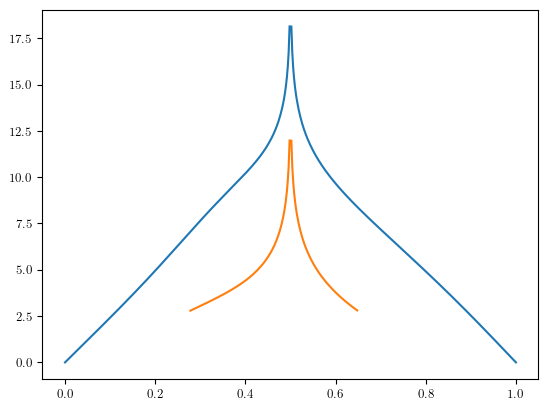

In [34]:
%matplotlib inline
@interact_manual(j=(1,n-1,1))
def do_(j): 
    tau_j = j/n
    P_j = cs_P(tau_j)
    Z_j = cs_Z(tau_j)

    
    Dr = np.sqrt((Z_array_range-Z_j)**2+(P_array_range-P_j)**2)
    plt.figure()
    Gzz_arr = G_zz_tilde_lam(P_j, Z_j - Z_array_range, P_array_range)
    plt.plot(tau_test_range, Gzz_arr, label=r'$\tilde G_{zz}$')
    Gzz_arr_close = 2*np.log(P_j/Dr)
    close_indexs = Dr<P_j/4
    plt.plot(tau_test_range[close_indexs], Gzz_arr_close[close_indexs] , label=r'$\tilde G_{zz}\left(\frac{\rho\rho_1}{\delta r^2}\ll 1\right)$')
    Gzz_arr_far = G_zz_tilde_close_asympt_lam(P_j, Z_j - Z_array_range, P_array_range)
    far_indexs = Dr<P_j/4
    plt.plot(tau_test_range[~close_indexs], Gzz_arr_far[~close_indexs], label=r'$G_{zz}(\frac{\rho\rho_1}{\delta r^2}\gg 1)$')
    #plt.plot(tau_test_range, G_zz_tilde_lam(P_j, Z_j - Z_array_range, P_array_range)-G_zz_tilde_close_asympt_lam(P_j, Z_j - Z_array_range, P_array_range), label=r'$G_{zz} - G_{zz}(\frac{\rho\rho_1}{\delta r^2}\ll 1)$')

    
    plt.grid()
    plt.ylim(0,20)
    plt.legend()

<IPython.core.display.Javascript object>


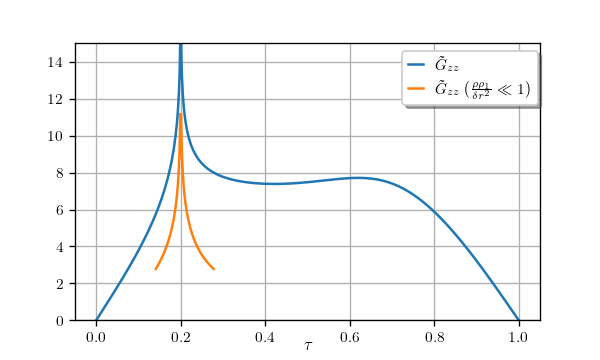

/tmp/ipykernel_145087/4267705379.py:11: RuntimeWarning: divide by zero encountered in divide
  Gzz_arr_close = 2*np.log(P_j/Dr)


In [46]:
j=200
tau_j = j/n
P_j = P_array_range[j]
Z_j = Z_array_range[j]


Dr = np.sqrt((Z_array_range-Z_j)**2+(P_array_range-P_j)**2)
plt.figure(figsize=(5,3))
Gzz_arr = G_zz_tilde_lam(P_j, Z_j - Z_array_range, P_array_range)
plt.plot(tau_test_range, Gzz_arr, label=r'$\tilde G_{zz}$')
Gzz_arr_close = 2*np.log(P_j/Dr)
close_indexs = Dr<P_j/4
plt.plot(tau_test_range[close_indexs], Gzz_arr_close[close_indexs] , label=r'$\tilde G_{zz}\left(\frac{\rho\rho_1}{\delta r^2}\ll 1\right)$')
Gzz_arr_far = G_zz_tilde_far_asympt_lam(P_j, Z_j - Z_array_range, P_array_range)
#far_indexs = Dr<P_j/4
#plt.plot(tau_test_range[~close_indexs], Gzz_arr_far[~close_indexs], label=r'$G_{zz}(\frac{\rho\rho_1}{\delta r^2}\gg 1)$')
#plt.plot(tau_test_range, G_zz_tilde_lam(P_j, Z_j - Z_array_range, P_array_range)-G_zz_tilde_close_asympt_lam(P_j, Z_j - Z_array_range, P_array_range), label=r'$G_{zz} - G_{zz}(\frac{\rho\rho_1}{\delta r^2}\ll 1)$')



plt.legend(loc='upper center', bbox_to_anchor=(0.85, 1.0),
          fancybox=True, shadow=True, ncol=1, fontsize=9, handlelength=1)



plt.grid()
plt.ylim(0,15)
plt.xlabel(r'$\tau$', labelpad=-4)
plt.savefig(f'G_zz_dem_j={j}'+'.pdf',bbox_inches="tight")
#plt.legend()

<IPython.core.display.Javascript object>


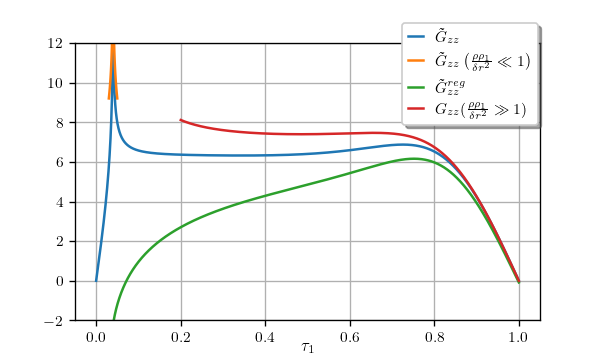

/tmp/ipykernel_145087/3451632754.py:12: RuntimeWarning: divide by zero encountered in divide
  Gzz_arr_close = 2*np.log(np.abs(1/(tau_j-tau_test_range)))


Text(0.5, 0, '$\\tau_1$')

In [86]:
j=200
tau_j = j/N
P_j = P_array_range[j]
Z_j = Z_array_range[j]


Dr = np.sqrt((Z_array_range-Z_j)**2+(P_array_range-P_j)**2)
plt.figure(figsize=(5,3))
Gzz_arr = G_zz_tilde_lam(P_j, Z_j - Z_array_range, P_array_range)
plt.plot(tau_test_range, Gzz_arr, label=r'$\tilde G_{zz}$')

Gzz_arr_close = 2*np.log(np.abs(1/(tau_j-tau_test_range)))
close_indexs = Dr<P_j/4

plt.plot(tau_test_range[close_indexs], Gzz_arr_close[close_indexs] , label=r'$\tilde G_{zz}\left(\frac{\rho\rho_1}{\delta r^2}\ll 1\right)$')

plt.plot(tau_test_range, Gzz_arr-Gzz_arr_close , label=r'$\tilde G_{zz}^{reg}$')

Gzz_arr_far = G_zz_tilde_far_asympt_lam(P_j, Z_j - Z_array_range, P_array_range)
plt.plot(tau_test_range[(~close_indexs)*(tau_test_range>5*tau_j)], 
         Gzz_arr_far[(~close_indexs)*(tau_test_range>5*tau_j)], label=r'$G_{zz}(\frac{\rho\rho_1}{\delta r^2}\gg 1)$')
    




plt.legend(loc='upper center', bbox_to_anchor=(0.85, 1.1),
          fancybox=True, shadow=True, ncol=1, fontsize=9, handlelength=1)



plt.grid()
plt.ylim(-2,12)
plt.xlabel(r'$\tau_1$', labelpad=-4)
#plt.savefig(f'G_zz_dem_j={j}'+'.pdf',bbox_inches="tight")
#plt.savefig(f'G_zz_dem_j={j}'+'.png',bbox_inches="tight", dpi=500)

#plt.legend()

<IPython.core.display.Javascript object>


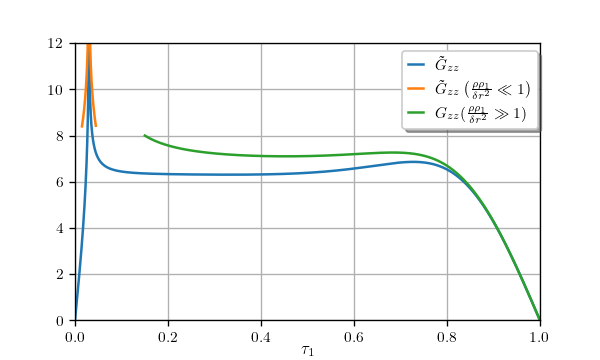

In [90]:
j=150
tau_j = j/N
P_j = P_array_range[j]
Z_j = Z_array_range[j]


Dr = np.sqrt((Z_array_range-Z_j)**2+(P_array_range-P_j)**2)
plt.figure(figsize=(5,3))
Gzz_arr = G_zz_tilde_lam(P_j, Z_j - Z_array_range, P_array_range)
plt.plot(tau_test_range, Gzz_arr, label=r'$\tilde G_{zz}$')

Gzz_arr_close = 2*np.log(np.abs(1/(tau_j-tau_test_range)))
close_indexs = np.abs(tau_test_range-tau_j)<tau_j/2

plt.plot(tau_test_range[close_indexs], Gzz_arr_close[close_indexs] , label=r'$\tilde G_{zz}\left(\frac{\rho\rho_1}{\delta r^2}\ll 1\right)$')

#plt.plot(tau_test_range, Gzz_arr-Gzz_arr_close , label=r'$\tilde G_{zz}^{reg}$')

Gzz_arr_far = G_zz_tilde_far_asympt_lam(P_j, Z_j - Z_array_range, P_array_range)
plt.plot(tau_test_range[(~close_indexs)*(tau_test_range>5*tau_j)], 
         Gzz_arr_far[(~close_indexs)*(tau_test_range>5*tau_j)], label=r'$G_{zz}(\frac{\rho\rho_1}{\delta r^2}\gg 1)$')
    





plt.legend(loc='upper center', bbox_to_anchor=(0.85, 1.0),
          fancybox=True, shadow=True, ncol=1, fontsize=9, handlelength=1)



plt.grid()
plt.ylim(0,12)
plt.xlim(0,1)
plt.xlabel(r'$\tau_1$', labelpad=-2)
plt.savefig(f'G_zz_dem_j={j}_{N}'+'.pdf',bbox_inches="tight")
plt.savefig(f'G_zz_dem_j={j}_{N}'+'.png',bbox_inches="tight", dpi=500)

#plt.legend()

<IPython.core.display.Javascript object>


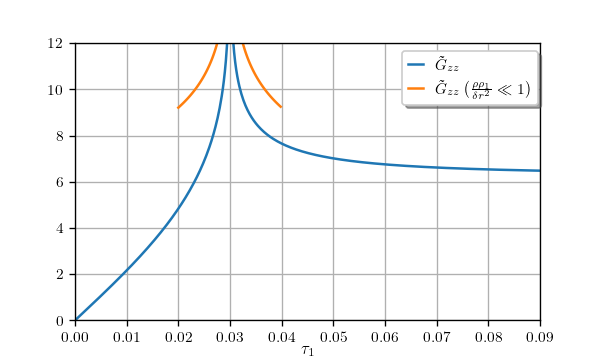

<lambdifygenerated-4>:2: RuntimeWarning: divide by zero encountered in divide
  return 4*rho_1*(z**2*elliptic_e(-4*rho*rho_1/(z**2 + (rho - rho_1)**2))/(z**2 + (rho + rho_1)**2) + elliptic_k(-4*rho*rho_1/(z**2 + (rho - rho_1)**2)))/sqrt(z**2 + (rho - rho_1)**2)
<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in multiply
  return 4*rho_1*(z**2*elliptic_e(-4*rho*rho_1/(z**2 + (rho - rho_1)**2))/(z**2 + (rho + rho_1)**2) + elliptic_k(-4*rho*rho_1/(z**2 + (rho - rho_1)**2)))/sqrt(z**2 + (rho - rho_1)**2)


In [94]:
j=150
tau_j = j/N
P_j = P_array_range[j]
Z_j = Z_array_range[j]


Dr = np.sqrt((Z_array_range-Z_j)**2+(P_array_range-P_j)**2)
plt.figure(figsize=(5,3))
Gzz_arr = G_zz_tilde_lam(P_j, Z_j - Z_array_range, P_array_range)
plt.plot(tau_test_range, Gzz_arr, label=r'$\tilde G_{zz}$')

Gzz_arr_close = 2*np.log(np.abs(1/(tau_j-tau_test_range)))
close_indexs = np.abs(tau_test_range-tau_j)<tau_j/3

plt.plot(tau_test_range[close_indexs], Gzz_arr_close[close_indexs] , label=r'$\tilde G_{zz}\left(\frac{\rho\rho_1}{\delta r^2}\ll 1\right)$')

#plt.plot(tau_test_range, Gzz_arr-Gzz_arr_close , label=r'$\tilde G_{zz}^{reg}$')

#Gzz_arr_far = G_zz_tilde_far_asympt_lam(P_j, Z_j - Z_array_range, P_array_range)
#plt.plot(tau_test_range[(~close_indexs)*(tau_test_range>5*tau_j)], 
#         Gzz_arr_far[(~close_indexs)*(tau_test_range>5*tau_j)], label=r'$G_{zz}(\frac{\rho\rho_1}{\delta r^2}\gg 1)$')
    





plt.legend(loc='upper center', bbox_to_anchor=(0.85, 1.0),
          fancybox=True, shadow=True, ncol=1, fontsize=9, handlelength=1)



plt.grid()
plt.ylim(0,12)
plt.xlim(0,3*tau_j)
plt.xlabel(r'$\tau_1$', labelpad=-2)
plt.savefig(f'G_zz_dem_j={j}_{N}_close'+'.pdf',bbox_inches="tight")
plt.savefig(f'G_zz_dem_j={j}_{N}_close'+'.png',bbox_inches="tight", dpi=500)

#plt.legend()

<IPython.core.display.Javascript object>


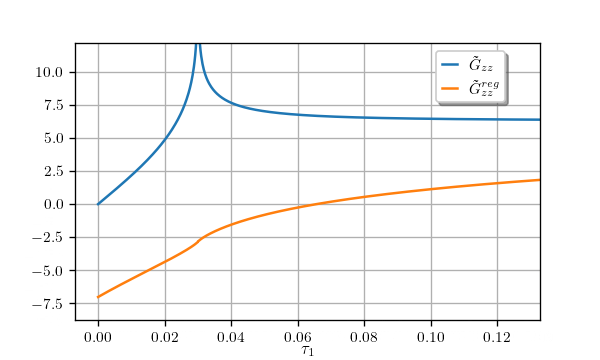

<lambdifygenerated-4>:2: RuntimeWarning: divide by zero encountered in divide
  return 4*rho_1*(z**2*elliptic_e(-4*rho*rho_1/(z**2 + (rho - rho_1)**2))/(z**2 + (rho + rho_1)**2) + elliptic_k(-4*rho*rho_1/(z**2 + (rho - rho_1)**2)))/sqrt(z**2 + (rho - rho_1)**2)
<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in multiply
  return 4*rho_1*(z**2*elliptic_e(-4*rho*rho_1/(z**2 + (rho - rho_1)**2))/(z**2 + (rho + rho_1)**2) + elliptic_k(-4*rho*rho_1/(z**2 + (rho - rho_1)**2)))/sqrt(z**2 + (rho - rho_1)**2)


Text(0.5, 0, '$\\tau_1$')

In [96]:
j=150
tau_j = j/N
P_j = P_array_range[j]
Z_j = Z_array_range[j]


Dr = np.sqrt((Z_array_range-Z_j)**2+(P_array_range-P_j)**2)
plt.figure(figsize=(5,3))
Gzz_arr = G_zz_tilde_lam(P_j, Z_j - Z_array_range, P_array_range)
plt.plot(tau_test_range, Gzz_arr, label=r'$\tilde G_{zz}$')

Gzz_arr_close = 1*2*np.log(np.abs(1/(tau_j-tau_test_range)))
close_indexs = np.abs(tau_test_range-tau_j)<tau_j/3

plt.plot(tau_test_range, Gzz_arr-Gzz_arr_close , label=r'$\tilde G_{zz}^{reg}$')

#plt.plot(tau_test_range, Gzz_arr-Gzz_arr_close , label=r'$\tilde G_{zz}^{reg}$')

#Gzz_arr_far = G_zz_tilde_far_asympt_lam(P_j, Z_j - Z_array_range, P_array_range)
#plt.plot(tau_test_range[(~close_indexs)*(tau_test_range>5*tau_j)], 
#         Gzz_arr_far[(~close_indexs)*(tau_test_range>5*tau_j)], label=r'$G_{zz}(\frac{\rho\rho_1}{\delta r^2}\gg 1)$')
    





plt.legend(loc='upper center', bbox_to_anchor=(0.85, 1.0),
          fancybox=True, shadow=True, ncol=1, fontsize=9, handlelength=1)



plt.grid()
plt.ylim(0,12)
plt.xlim(0,3*tau_j)
plt.xlabel(r'$\tau_1$', labelpad=-2)
#plt.savefig(f'G_zz_dem_j={j}_{N}_close'+'.pdf',bbox_inches="tight")
#plt.savefig(f'G_zz_dem_j={j}_{N}_close'+'.png',bbox_inches="tight", dpi=500)

#plt.legend()

In [35]:
G_zz_tilde_far_asympt = G_zz_tilde.subs({elliptic_k(-nu_sub.subs(delta_r, delta_r_sub)): pi/2, 
                                         elliptic_e(-nu_sub.subs(delta_r, delta_r_sub)): pi/2})
G_zz_tilde_far_asympt = simplify(G_zz_tilde_far_asympt)
G_zz_tilde_far_asympt_lam = lambdify([rho,z,rho_1], G_zz_tilde_far_asympt)

In [70]:
%matplotlib notebook
@interact_manual(j=(1,n-1,1))
def do_(j): 
    div_v = 0
    tau_j = j/n
    P_j = cs_P(tau_j)
    Z_j = cs_Z(tau_j)
    P_x_j = cs_P(tau_j,1)
    Z_x_j = cs_Z(tau_j,1)

    
    
    plt.figure()
    plt.plot(tau_test_range, G_zz_tilde_lam(P_j, Z_j - Z_array_range, P_array_range), label=r'$G_{zz}$')
    #plt.plot(tau_test_range, G_zz_tilde_far_asympt_lam(P_j, Z_j - Z_array_range, P_array_range), label=r'$G_{zz}(\frac{\rho\rho_1}{\delta r^2}\ll 1)$')
    plt.plot(tau_test_range, G_zz_tilde_close_asympt_lam(P_j, Z_j - Z_array_range, P_array_range), label=r'$G_{zz}(\frac{\rho\rho_1}{\delta r^2}\gg 1)$')
    plt.plot(tau_test_range, G_zz_tilde_lam(P_j, Z_j - Z_array_range, P_array_range)-G_zz_tilde_close_asympt_lam(P_j, Z_j - Z_array_range, P_array_range), label=r'$G_{zz} - G_{zz}(\frac{\rho\rho_1}{\delta r^2}\gg 1)$')

    
    plt.grid()
    plt.ylim(0,20)
    plt.legend()

interactive(children=(IntSlider(value=500, description='j', max=999, min=1), Button(description='Run Interact'…

In [38]:
G_zz_tilde

4*rho_1*(z**2*elliptic_e(-4*rho*rho_1/(z**2 + (rho - rho_1)**2))/(z**2 + (rho + rho_1)**2) + elliptic_k(-4*rho*rho_1/(z**2 + (rho - rho_1)**2)))/sqrt(z**2 + (rho - rho_1)**2)

In [39]:
nu_arg = nu_sub.subs(delta_r, delta_r_sub)

In [40]:
from sympy import log

In [41]:
G_zz_tilde_close_asympt = G_zz_tilde.subs({elliptic_e(-nu_arg): \
                                           sqrt(nu_arg)+log(16*nu_arg)/sqrt(nu_arg)/4, 
                                         elliptic_k(-nu_arg): \
                                           log(nu_arg)/sqrt(nu_arg)/2})
G_zz_tilde_close_asympt = simplify(G_zz_tilde_close_asympt)
G_zz_tilde_close_asympt_lam = lambdify([rho,z,rho_1], G_zz_tilde_close_asympt)

In [46]:
%matplotlib inline
@interact_manual(j=(1,n-1,1))
def do_(j): 
    div_v = 0
    tau_j = j/n
    P_j = cs_P(tau_j)
    Z_j = cs_Z(tau_j)
    P_x_j = cs_P(tau_j,1)
    Z_x_j = cs_Z(tau_j,1)
    v_sqr_j = P_x_j**2 + Z_x_j**2
    force_j = s_force(tau_j)
    mul_pt = Z_x_j/P_j*(1+2*P_x_j**2/v_sqr_j)*force_j
    
    
    
    
    def D_rho_lam(rho__1, z__1): 
        return P_x_j**2/v_sqr_j*dG_rhorho_rho_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            Z_x_j**2/v_sqr_j*dG_zrho_z_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            P_x_j*Z_x_j/v_sqr_j*(
            dG_rhorho_z_tilde_lam(P_j, Z_j - z__1, rho__1) + dG_zrho_rho_tilde_lam(P_j, Z_j - z__1, rho__1)) +\
            G_rhorho_tilde_lam(P_j, Z_j - z__1, rho__1)/P_j
    
    def D_z_lam(rho__1, z__1): 
        return P_x_j**2/v_sqr_j*dG_rhoz_rho_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            Z_x_j**2/v_sqr_j*dG_zz_z_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            P_x_j*Z_x_j/v_sqr_j*(
            dG_rhoz_z_tilde_lam(P_j, Z_j - z__1, rho__1) + dG_zz_rho_tilde_lam(P_j, Z_j - z__1, rho__1)) +\
            G_rhoz_tilde_lam(P_j, Z_j - z__1, rho__1)/P_j
    
    ### Integrals ###
    fun_range = (P_tau_range*D_z_lam(P_array_range, Z_array_range) \
                    -Z_tau_range*D_rho_lam(P_array_range, Z_array_range))*\
                        force_by_delta -\
                    mul_pt*np.log(np.abs(tau_test_range-tau_j))
    fun_range[j]=(fun_range[j-1]+fun_range[j+1])/2

    
    
    plt.figure()
    plt.plot(fun_range, '.--')
    plt.grid()

interactive(children=(IntSlider(value=50, description='j', max=99, min=1), Button(description='Run Interact', …

In [50]:
%matplotlib inline
@interact_manual(j=(1,n-1,1))
def do_(j): 
    div_v = 0
    tau_j = j/n
    P_j = cs_P(tau_j)
    Z_j = cs_Z(tau_j)
    P_x_j = cs_P(tau_j,1)
    Z_x_j = cs_Z(tau_j,1)
    v_sqr_j = P_x_j**2 + Z_x_j**2
    #force_j = s_force(tau_j)
    #mul_pt = Z_x_j/P_j*(1+2*P_x_j**2/v_sqr_j)*force_j
    
    
    
    
    def D_rho_lam(rho__1, z__1): 
        return P_x_j**2/v_sqr_j*dG_rhorho_rho_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            Z_x_j**2/v_sqr_j*dG_zrho_z_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            P_x_j*Z_x_j/v_sqr_j*(
            dG_rhorho_z_tilde_lam(P_j, Z_j - z__1, rho__1) + dG_zrho_rho_tilde_lam(P_j, Z_j - z__1, rho__1)) +\
            G_rhorho_tilde_lam(P_j, Z_j - z__1, rho__1)/P_j
    
    def D_z_lam(rho__1, z__1): 
        return P_x_j**2/v_sqr_j*dG_rhoz_rho_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            Z_x_j**2/v_sqr_j*dG_zz_z_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            P_x_j*Z_x_j/v_sqr_j*(
            dG_rhoz_z_tilde_lam(P_j, Z_j - z__1, rho__1) + dG_zz_rho_tilde_lam(P_j, Z_j - z__1, rho__1)) +\
            G_rhoz_tilde_lam(P_j, Z_j - z__1, rho__1)/P_j
    
    ### Integrals ###
    fun_range = (P_tau_range*D_z_lam(P_array_range, Z_array_range) \
                    -Z_tau_range*D_rho_lam(P_array_range, Z_array_range))#*\
                    #    force_by_delta -\
                    #mul_pt*np.log(np.abs(tau_test_range-tau_j))
    #fun_range[j]=(fun_range[j-1]+fun_range[j+1])/2

    
    
    plt.figure()
    plt.plot(fun_range, '.--')
    plt.grid()

interactive(children=(IntSlider(value=50, description='j', max=99, min=1), Button(description='Run Interact', …

In [51]:
%matplotlib inline
@interact_manual(j=(1,n-1,1))
def do_(j): 
    div_v = 0
    tau_j = j/n
    P_j = cs_P(tau_j)
    Z_j = cs_Z(tau_j)
    P_x_j = cs_P(tau_j,1)
    Z_x_j = cs_Z(tau_j,1)
    v_sqr_j = P_x_j**2 + Z_x_j**2
    #force_j = s_force(tau_j)
    mul_pt = Z_x_j/P_j*(1+2*P_x_j**2/v_sqr_j)#*force_j
    
    
    
    
    def D_rho_lam(rho__1, z__1): 
        return P_x_j**2/v_sqr_j*dG_rhorho_rho_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            Z_x_j**2/v_sqr_j*dG_zrho_z_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            P_x_j*Z_x_j/v_sqr_j*(
            dG_rhorho_z_tilde_lam(P_j, Z_j - z__1, rho__1) + dG_zrho_rho_tilde_lam(P_j, Z_j - z__1, rho__1)) +\
            G_rhorho_tilde_lam(P_j, Z_j - z__1, rho__1)/P_j
    
    def D_z_lam(rho__1, z__1): 
        return P_x_j**2/v_sqr_j*dG_rhoz_rho_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            Z_x_j**2/v_sqr_j*dG_zz_z_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            P_x_j*Z_x_j/v_sqr_j*(
            dG_rhoz_z_tilde_lam(P_j, Z_j - z__1, rho__1) + dG_zz_rho_tilde_lam(P_j, Z_j - z__1, rho__1)) +\
            G_rhoz_tilde_lam(P_j, Z_j - z__1, rho__1)/P_j
    
    ### Integrals ###
    fun_range = (P_tau_range*D_z_lam(P_array_range, Z_array_range) \
                    -Z_tau_range*D_rho_lam(P_array_range, Z_array_range))\
                    -mul_pt*np.log(np.abs(tau_test_range-tau_j))
                    #*\
                    #    force_by_delta -\
                    #mul_pt*np.log(np.abs(tau_test_range-tau_j))
    #fun_range[j]=(fun_range[j-1]+fun_range[j+1])/2

    
    
    plt.figure()
    plt.plot(fun_range, '.--')
    plt.grid()

interactive(children=(IntSlider(value=50, description='j', max=99, min=1), Button(description='Run Interact', …

In [ ]:
%matplotlib inline
@interact_manual(j=(1,n-1,1))
def do_(j): 
    div_v = 0
    tau_j = j/n
    P_j = cs_P(tau_j)
    Z_j = cs_Z(tau_j)
    P_x_j = cs_P(tau_j,1)
    Z_x_j = cs_Z(tau_j,1)
    v_sqr_j = P_x_j**2 + Z_x_j**2
    #force_j = s_force(tau_j)
    #mul_pt = Z_x_j/P_j*(1+2*P_x_j**2/v_sqr_j)*force_j
    
    
    
    
    def D_rho_lam(rho__1, z__1): 
        return P_x_j**2/v_sqr_j*dG_rhorho_rho_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            Z_x_j**2/v_sqr_j*dG_zrho_z_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            P_x_j*Z_x_j/v_sqr_j*(
            dG_rhorho_z_tilde_lam(P_j, Z_j - z__1, rho__1) + dG_zrho_rho_tilde_lam(P_j, Z_j - z__1, rho__1)) +\
            G_rhorho_tilde_lam(P_j, Z_j - z__1, rho__1)/P_j
    
    def D_z_lam(rho__1, z__1): 
        return P_x_j**2/v_sqr_j*dG_rhoz_rho_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            Z_x_j**2/v_sqr_j*dG_zz_z_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            P_x_j*Z_x_j/v_sqr_j*(
            dG_rhoz_z_tilde_lam(P_j, Z_j - z__1, rho__1) + dG_zz_rho_tilde_lam(P_j, Z_j - z__1, rho__1)) +\
            G_rhoz_tilde_lam(P_j, Z_j - z__1, rho__1)/P_j
    
    ### Integrals ###
    fun_range = (P_tau_range*D_z_lam(P_array_range, Z_array_range) \
                    -Z_tau_range*D_rho_lam(P_array_range, Z_array_range))#*\
                    #    force_by_delta -\
                    #mul_pt*np.log(np.abs(tau_test_range-tau_j))
    #fun_range[j]=(fun_range[j-1]+fun_range[j+1])/2

    
    
    plt.figure()
    plt.plot(fun_range, '.--')
    plt.grid()

In [47]:
%matplotlib inline
@interact_manual(j=(1,n-1,1))
def do_(j): 
    div_v = 0
    tau_j = j/n
    P_j = cs_P(tau_j)
    Z_j = cs_Z(tau_j)
    P_x_j = cs_P(tau_j,1)
    Z_x_j = cs_Z(tau_j,1)
    v_sqr_j = P_x_j**2 + Z_x_j**2
    force_j = s_force(tau_j)
    mul_pt = Z_x_j/P_j*(1+2*P_x_j**2/v_sqr_j)
    
    
    
    
    def D_rho_lam(rho__1, z__1): 
        return P_x_j**2/v_sqr_j*dG_rhorho_rho_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            Z_x_j**2/v_sqr_j*dG_zrho_z_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            P_x_j*Z_x_j/v_sqr_j*(
            dG_rhorho_z_tilde_lam(P_j, Z_j - z__1, rho__1) + dG_zrho_rho_tilde_lam(P_j, Z_j - z__1, rho__1)) +\
            G_rhorho_tilde_lam(P_j, Z_j - z__1, rho__1)/P_j
    
    def D_z_lam(rho__1, z__1): 
        return P_x_j**2/v_sqr_j*dG_rhoz_rho_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            Z_x_j**2/v_sqr_j*dG_zz_z_tilde_lam(P_j, Z_j - z__1, rho__1) +\
            P_x_j*Z_x_j/v_sqr_j*(
            dG_rhoz_z_tilde_lam(P_j, Z_j - z__1, rho__1) + dG_zz_rho_tilde_lam(P_j, Z_j - z__1, rho__1)) +\
            G_rhoz_tilde_lam(P_j, Z_j - z__1, rho__1)/P_j
    
    ### Integrals ###
    fun_range = (P_tau_range*D_z_lam(P_array_range, Z_array_range) \
                    -Z_tau_range*D_rho_lam(P_array_range, Z_array_range))\
                         -\
                    mul_pt*np.log(np.abs(tau_test_range-tau_j))
    fun_range[j]=(fun_range[j-1]+fun_range[j+1])/2

    
    
    plt.figure()
    plt.plot(fun_range, '.--')
    plt.grid()

interactive(children=(IntSlider(value=50, description='j', max=99, min=1), Button(description='Run Interact', …

<IPython.core.display.Javascript object>


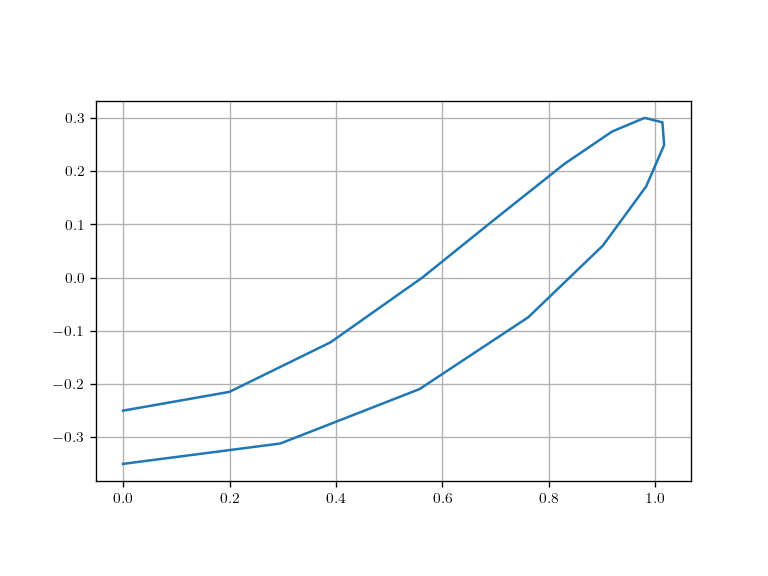

(-0.050822567695166444,
 1.0672739215984952,
 -0.38249875070918965,
 0.33247376489298286)

In [284]:
%matplotlib notebook
test_P = sin(pi*tau)-0.1*sin(2*pi*tau)
test_P = test_P.subs(tau, tau_through_tau_s)
test_Z =  0.05*cos(pi*tau)-0.3*cos(pi*2*tau)
test_Z = test_Z.subs(tau, tau_through_tau_s)

N=15

tau_test_range = np.linspace(0,1,N+1, endpoint=True)
P_array_range = np.array([test_P.evalf(subs={tau:_}) for _ in tau_test_range], dtype=float)
Z_array_range = np.array([test_Z.evalf(subs={tau:_}) for _ in tau_test_range], dtype=float)
P_array_range[-1]=0


plt.figure()
plt.grid()

#plt.ylim(0,15)
plt.plot(P_array_range, Z_array_range)
plt.axis('scaled')

In [285]:
n=N

In [114]:
%matplotlib inline
@interact_manual(j=(1,n-1,1))
def do_(j): 

    
    dr_sqr = (P_array_range-P_array_range[j])**2 + (Z_array_range-Z_array_range[j])**2
    par_array = np.sqrt(dr_sqr)/P_array_range[j]
    #dnu_arr = nu_arr[1:]-nu_arr[:-1]
    #tau_loc = N*dnu_arr/(nu_arr[1:]+nu_arr[:-1])*2
    plt.figure()
    plt.plot(tau_test_range, par_array, '.')
    plt.grid()

interactive(children=(IntSlider(value=25, description='j', max=49, min=1), Button(description='Run Interact', …

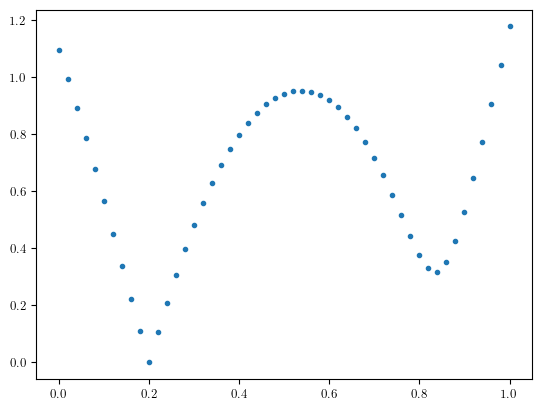

In [190]:
j=10
dr_sqr = (P_array_range-P_array_range[j])**2 + (Z_array_range-Z_array_range[j])**2
dr_ov_P = np.sqrt(dr_sqr)/P_array_range[j]

#dnu_arr = nu_arr[1:]-nu_arr[:-1]
#tau_loc = N*dnu_arr/(nu_arr[1:]+nu_arr[:-1])*2
plt.figure()
plt.plot(tau_test_range, dr_ov_P, '.')

In [191]:
j_array = np.arange(N+1)
j_array, (j_array[:-1])[(dr_ov_P-1.1)[1::]*(dr_ov_P-1.1)[:-1:]<0]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 array([49]))

In [192]:
intesive_zone = dr_ov_P<0.5
intesive_zone

array([False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False])

In [193]:
intesive_j=np.where(intesive_zone)[0]

In [194]:
intesive_j

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 39, 40, 41, 42, 43, 44])

In [195]:
r_bounds = intesive_j[:-1][(intesive_j[1:]-intesive_j[:-1])>1]
r_bounds = np.append(r_bounds, intesive_j[-1])
l_bounds = intesive_j[1:][(intesive_j[1:]-intesive_j[:-1])>1]
l_bounds = np.insert(l_bounds, 0, intesive_j[0])

zones = np.concatenate((l_bounds,r_bounds)).reshape(-1,2).T
zones

array([[ 6, 15],
       [39, 44]])

In [203]:
tau_star_arr = zones.mean(axis=1)/N
Delta_arr = (zones[:,1]-zones[:,0]+1)/2/N

tau_star_arr, Delta_arr

(array([0.21, 0.83]), array([0.1 , 0.06]))

In [207]:
quad_pts = [j/N+np.linspace(0,1, int((1/(Delta_arr + np.abs((j+0.5)/N-tau_star_arr))).sum()/3), endpoint=False)/N for j in j_array]
quad_pts

[array([0.]),
 array([0.02]),
 array([0.04]),
 array([0.06]),
 array([0.08]),
 array([0.1 , 0.11]),
 array([0.12, 0.13]),
 array([0.14, 0.15]),
 array([0.16, 0.17]),
 array([0.18      , 0.18666667, 0.19333333]),
 array([0.2       , 0.20666667, 0.21333333]),
 array([0.22      , 0.22666667, 0.23333333]),
 array([0.24, 0.25]),
 array([0.26, 0.27]),
 array([0.28, 0.29]),
 array([0.3 , 0.31]),
 array([0.32, 0.33]),
 array([0.34, 0.35]),
 array([0.36]),
 array([0.38]),
 array([0.4]),
 array([0.42]),
 array([0.44]),
 array([0.46]),
 array([0.48]),
 array([0.5]),
 array([0.52]),
 array([0.54]),
 array([0.56]),
 array([0.58]),
 array([0.6]),
 array([0.62]),
 array([0.64, 0.65]),
 array([0.66, 0.67]),
 array([0.68, 0.69]),
 array([0.7 , 0.71]),
 array([0.72, 0.73]),
 array([0.74, 0.75]),
 array([0.76      , 0.76666667, 0.77333333]),
 array([0.78      , 0.78666667, 0.79333333]),
 array([0.8  , 0.805, 0.81 , 0.815]),
 array([0.82      , 0.82333333, 0.82666667, 0.83      , 0.83333333,
        0.836

In [208]:
quad_pts_full = np.concatenate(tuple(quad_pts), axis=0)

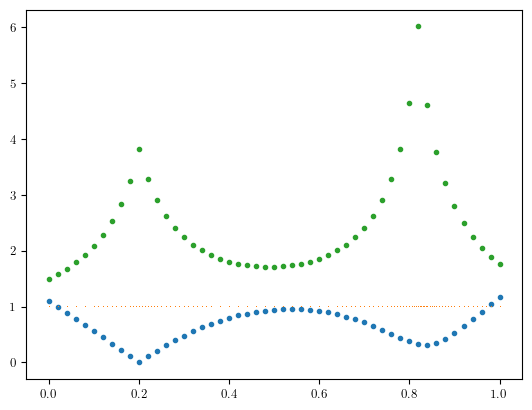

In [210]:
j=10
dr_sqr = (P_array_range-P_array_range[j])**2 + (Z_array_range-Z_array_range[j])**2
dr_ov_P = np.sqrt(dr_sqr)/P_array_range[j]

#dnu_arr = nu_arr[1:]-nu_arr[:-1]
#tau_loc = N*dnu_arr/(nu_arr[1:]+nu_arr[:-1])*2
plt.figure()
plt.plot(tau_test_range, dr_ov_P, '.')
plt.plot(quad_pts_full, quad_pts_full*0+1, ',')
plt.plot(j_array/N, [((1/(Delta_arr + np.abs((j+0.5)/N-tau_star_arr))).sum()/3) for j in j_array], '.')


In [286]:
P_extanded_range = np.zeros(2*N)
P_extanded_range[0:N+1]=P_array_range
P_extanded_range[N+1:]=-P_array_range[::-1][1:-1:]

Z_extanded_range = np.zeros(2*N)
Z_extanded_range[0:N+1]=Z_array_range
Z_extanded_range[N+1:]=Z_array_range[::-1][1:-1:]

<IPython.core.display.Javascript object>


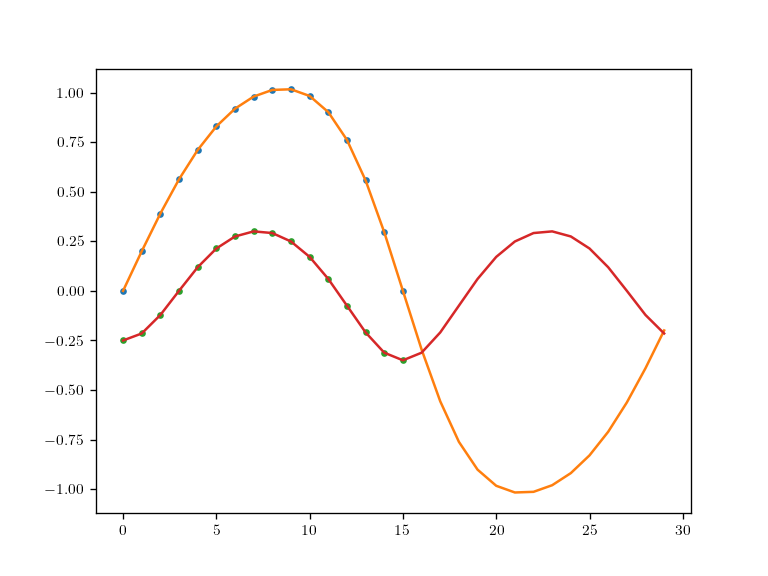

In [287]:
plt.figure()
plt.plot(P_array_range, '.')
plt.plot(P_extanded_range)

plt.plot(Z_array_range, '.')
plt.plot(Z_extanded_range)

In [288]:
P_fft = np.fft.rfft(P_extanded_range, norm="forward")
Z_fft = np.fft.rfft(Z_extanded_range, norm="forward")

In [271]:
%matplotlib notebook
test_P = sin(pi*tau)-0.1*sin(2*pi*tau)
test_P = test_P.subs(tau, tau_through_tau_s)
test_Z =  0.05*cos(pi*tau)-0.3*cos(pi*2*tau)
test_Z = test_Z.subs(tau, tau_through_tau_s)

N=500

tau_test_range = np.linspace(0,1,N+1, endpoint=True)
P_array_range = np.array([test_P.evalf(subs={tau:_}) for _ in tau_test_range], dtype=float)
Z_array_range = np.array([test_Z.evalf(subs={tau:_}) for _ in tau_test_range], dtype=float)
P_array_range[-1]=0

P_extanded_range_true = np.zeros(2*N)
P_extanded_range_true[0:N+1]=P_array_range
P_extanded_range_true[N+1:]=-P_array_range[::-1][1:-1:]

Z_extanded_range_true = np.zeros(2*N)
Z_extanded_range_true[0:N+1]=Z_array_range
Z_extanded_range_true[N+1:]=Z_array_range[::-1][1:-1:]

P_fft_true = np.fft.rfft(P_extanded_range_true, norm="forward")
Z_fft_true = np.fft.rfft(Z_extanded_range_true, norm="forward")

<IPython.core.display.Javascript object>


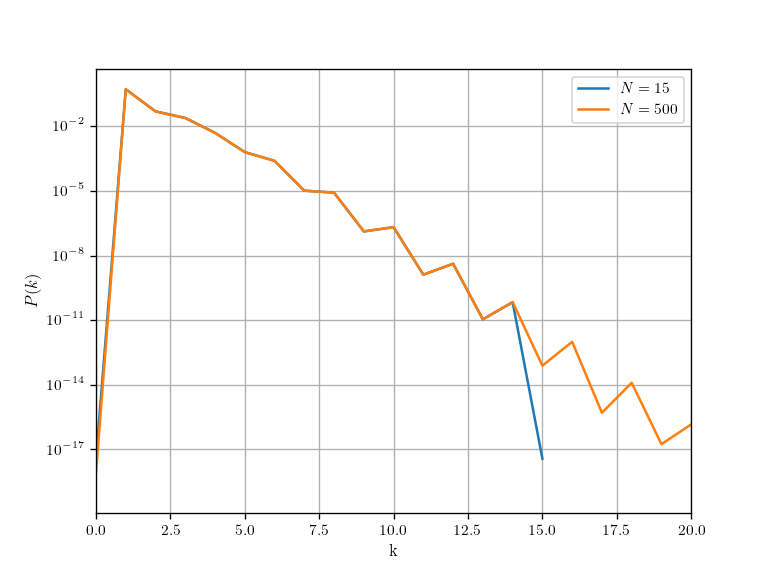

(0.0, 20.0)

In [291]:
%matplotlib notebook
plt.figure()
plt.plot(np.abs(P_fft), label=fr'$N={N}$')
plt.plot(np.abs(P_fft_true), label=r'$N=500$')

plt.legend()
plt.xlabel('k')
plt.ylabel(r'$P(k)$')
plt.grid()
plt.yscale('log')
plt.xlim(0,N+5)

In [333]:
P_fft.shape

(16,)

In [295]:
N

15

In [308]:
j_array = np.arange(N+1)
j_array

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [311]:
P_extanded_range.shape

(30,)

In [305]:
P_fft.shape

(16,)

<IPython.core.display.Javascript object>


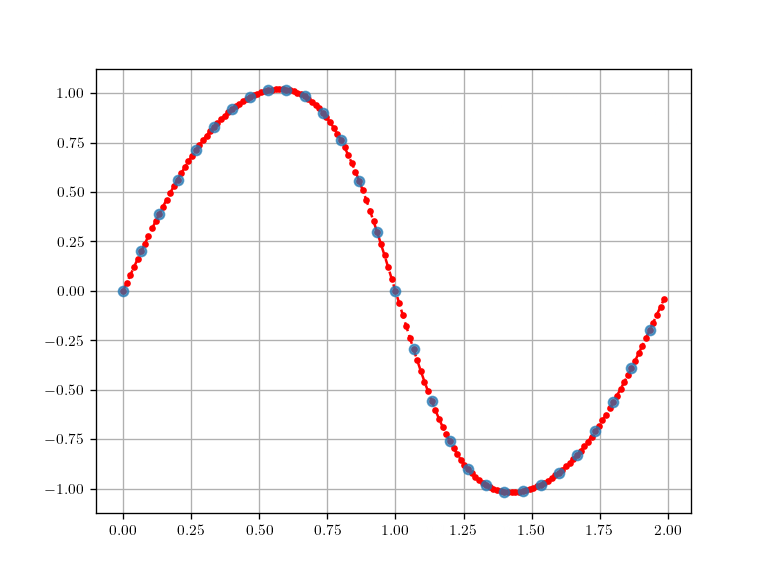

In [332]:
number_pts = 10*N
P_ifft = np.fft.irfft(P_fft, norm="forward", n=number_pts)
plt.plot(np.linspace(0,2,number_pts, endpoint=False), P_ifft,'.--', color='red')
P_ifft = np.fft.irfft( P_fft, norm="forward")
plt.plot(np.linspace(0,2,2*N, endpoint=False),P_ifft, 'o', alpha=0.7)
plt.grid()

<IPython.core.display.Javascript object>


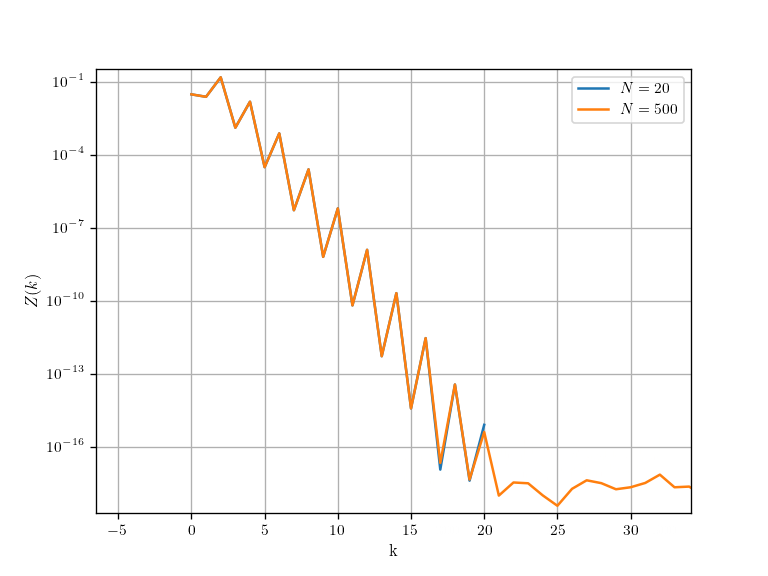

In [280]:
%matplotlib notebook
plt.figure()
plt.plot(np.abs(Z_fft), label=r'$N=20$')
plt.plot(np.abs(Z_fft_true), label=r'$N=500$')

plt.legend()
plt.xlabel('k')
plt.ylabel(r'$Z(k)$')
plt.grid()
plt.yscale('log')


In [334]:
N_int = 400

In [337]:
N

15

In [399]:
from scipy.special import sinc
def R(x):
    return sinc(x) / sinc(x/(2*N))*np.cos(np.pi*x/(2*N))

In [400]:
J_int = np.linspace(0, N, N_int, endpoint=True)
j_array_ext = np.arange(0,2*N)

In [401]:
dJ_int = J_int.reshape(-1,1) - j_array_ext.reshape(1,-1)
dJ_int.shape

(400, 30)

In [402]:
R_int_mesh = R(dJ_int)

<IPython.core.display.Javascript object>


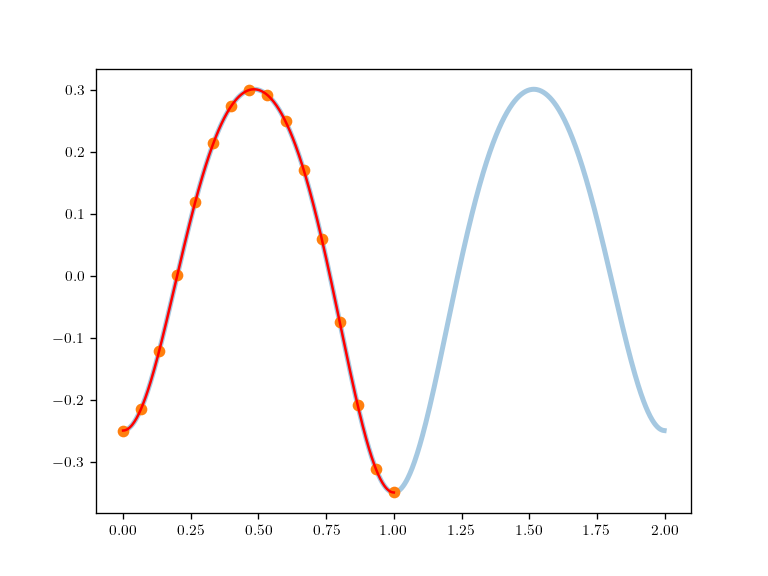

In [403]:
plt.figure()

plt.plot(np.linspace(0,2,1000,endpoint=False),Z_extanded_range_true, lw=3, alpha=0.4)
plt.plot(j_array/N, Z_array_range, 'o')
plt.plot(J_int/N, R_int_mesh @ Z_extanded_range, c='red')


In [404]:
from sympy.parsing.mathematica import parse_mathematica as prsmat

Nw = symbols('Nw')

In [460]:
R1_wol_str = '(Cot[(\[Pi] x)/(2 k)] Sin[\[Pi] x])/(2 k)'
R_wol_str = R_wol_str.replace('\[Pi]', 'pi').replace('k', 'Nw')
R_wol = prsmat(R_wol_str)
R_wol_lam = lambdify([x, Nw], R_wol)
R_wol

sin(pi*x)*cot(pi*x/(2*Nw))/(2*Nw)

In [462]:
R_int_mesh = R_wol_lam(dJ_int, N)
R_int_mesh[np.abs(dJ_int)<1e-6]=1

<IPython.core.display.Javascript object>


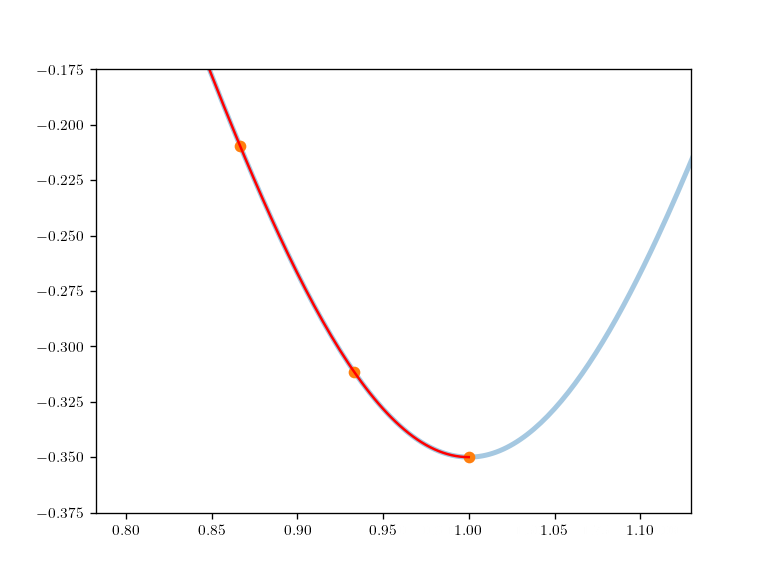

In [459]:
plt.figure()

plt.plot(np.linspace(0,2,1000,endpoint=False),Z_extanded_range_true, lw=3, alpha=0.4)
plt.plot(j_array/N, Z_array_range, 'o')
plt.plot(J_int/N, R_int_mesh @ Z_extanded_range, c='red')


In [576]:
R1_wol_str = '(\[Pi] (2 k Cos[\[Pi] x] Cot[(\[Pi] x)/(2 k)] - Csc[(\[Pi] x)/(2 k)]^2 Sin[\[Pi] x]))/(4 k^2)'
R1_wol_str = R1_wol_str.replace('\[Pi]', 'pi').replace('k', 'Nw')
R1_wol = prsmat(R1_wol_str)
R1_wol

pi*(2*Nw*cos(pi*x)*cot(pi*x/(2*Nw)) - sin(pi*x)*csc(pi*x/(2*Nw))**2)/(4*Nw**2)

In [592]:
R1_wol = simplify(R1_wol.rewrite('sincos'))
R1_wol_lam = lambdify([x,Nw], R1_wol, modules=['numpy'])
R1_wol

pi*(-Nw*sin(pi*x/Nw)*cos(pi*x) + sin(pi*x))/(2*Nw**2*(cos(pi*x/Nw) - 1))

In [593]:
R1_int_mesh = R1_wol_lam(dJ_int, N)
R1_int_mesh[np.abs(dJ_int)<1e-6]=0

<lambdifygenerated-68>:2: RuntimeWarning: invalid value encountered in divide
  return (1/2)*pi*(-Nw*sin(pi*x/Nw)*cos(pi*x) + sin(pi*x))/(Nw**2*(cos(pi*x/Nw) - 1))


In [594]:
test_P = sin(pi*tau)-0.1*sin(2*pi*tau)
test_P = test_P.subs(tau, tau_through_tau_s)
test_Z =  0.05*cos(pi*tau)-0.3*cos(pi*2*tau)
test_Z = test_Z.subs(tau, tau_through_tau_s)

N_true=500

tau_test_range_true = np.linspace(0,1,N_true+1, endpoint=True)
P_array_range_true = np.array([test_P.evalf(subs={tau:_}) for _ in tau_test_range_true], dtype=float)
Z_array_range_true = np.array([test_Z.evalf(subs={tau:_}) for _ in tau_test_range_true], dtype=float)

P_array_range_true[-1]=0

Z1_array_range_true = np.array([test_Z.diff(tau).evalf(subs={tau:_}) for _ in tau_test_range_true], dtype=float)


<IPython.core.display.Javascript object>


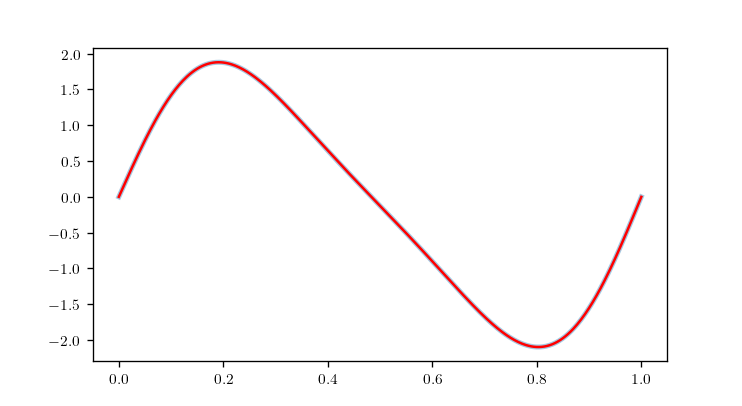

In [598]:
plt.figure()

plt.plot(tau_test_range_true, Z1_array_range_true, lw=3, alpha=0.4)
plt.plot(J_int/N, R1_int_mesh @ Z_extanded_range*N, c='red')

In [599]:
R2_wol_str = '(\[Pi]^2 Csc[(\[Pi] x)/(2 k)]^2 (-2 k Cos[\[Pi] x]+Sin[\[Pi] x] (Cot[(\[Pi] x)/(2 k)]-k^2 Sin[(\[Pi] x)/k])))/(4 k^3)'
R2_wol_str = R2_wol_str.replace('\[Pi]', 'pi').replace('k', 'Nw')
R2_wol = prsmat(R2_wol_str)
R2_wol

pi**2*(-2*Nw*cos(pi*x) + (-Nw**2*sin(pi*x/Nw) + cot(pi*x/(2*Nw)))*sin(pi*x))*csc(pi*x/(2*Nw))**2/(4*Nw**3)

In [600]:
R2_wol = simplify(R2_wol.rewrite('sincos'))
R2_wol_lam = lambdify([x,Nw], R2_wol, modules=['numpy'])
R2_wol

pi**2*(-Nw**2*sin(pi*x)*sin(pi*x/Nw) - 2*Nw*cos(pi*x) + sin(pi*x)/tan(pi*x/(2*Nw)))/(4*Nw**3*sin(pi*x/(2*Nw))**2)

In [602]:
R2_int_mesh = R2_wol_lam(dJ_int, N)
R2_int_mesh[np.abs(dJ_int)<1e-6]=-(((1 + 2*N**2) *np.pi**2)/(6 *N**2))

<lambdifygenerated-69>:2: RuntimeWarning: invalid value encountered in divide
  return (1/4)*pi**2*(-Nw**2*sin(pi*x)*sin(pi*x/Nw) - 2*Nw*cos(pi*x) + sin(pi*x)/tan((1/2)*pi*x/Nw))/(Nw**3*sin((1/2)*pi*x/Nw)**2)


In [603]:
test_P = sin(pi*tau)-0.1*sin(2*pi*tau)
test_P = test_P.subs(tau, tau_through_tau_s)
test_Z =  0.05*cos(pi*tau)-0.3*cos(pi*2*tau)
test_Z = test_Z.subs(tau, tau_through_tau_s)

N_true=500

tau_test_range_true = np.linspace(0,1,N_true+1, endpoint=True)
P_array_range_true = np.array([test_P.evalf(subs={tau:_}) for _ in tau_test_range_true], dtype=float)
Z_array_range_true = np.array([test_Z.evalf(subs={tau:_}) for _ in tau_test_range_true], dtype=float)

P_array_range_true[-1]=0

Z2_array_range_true = np.array([test_Z.diff(tau,2).evalf(subs={tau:_}) for _ in tau_test_range_true], dtype=float)


<IPython.core.display.Javascript object>


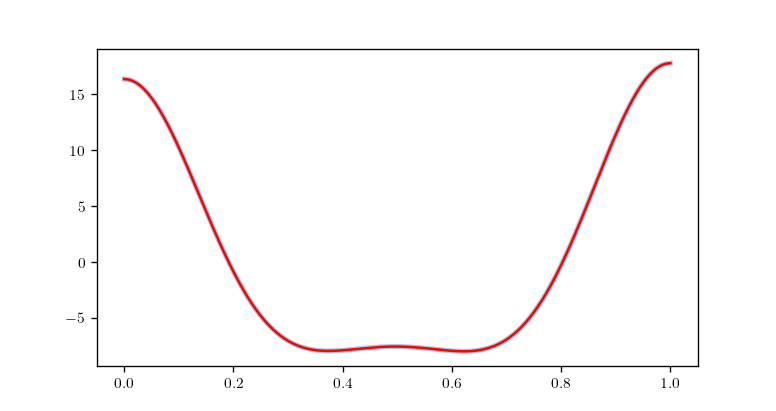

In [604]:
plt.figure()

plt.plot(tau_test_range_true, Z2_array_range_true, lw=3, alpha=0.4)
plt.plot(J_int/N, R2_int_mesh @ Z_extanded_range*(N**2), c='red')